# Apply pixel normalization in 2D brain Dataset.

### Import required libraries

In [2]:
import os
import cv2
import time
import random

import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

from pathlib import Path

### Import useful codes from previous notebooks.

In [ ]:
class EvaluateDataframe():

    def __init__(self, df):
        self.df = df


    def get_ds_indexes(self, ds_name):
        indexes = self.df[self.df.Orig_Dataset == ds_name].index
        return indexes[0], indexes[-1]


    def return_df(self):
        return self.df 


    def plot_images(self, first_idx=0, last_idx=None):

        if last_idx is None: last_idx = len(self.df)

        idx = first_idx
        
        poss_cmd = ['n', 'p', 'label', 'rot', 'end']

        while idx != last_idx:
            row = self.df.iloc[idx]
            img = row.Image
            
            plt.figure(figsize=(10,8))
            plt.imshow(img, cmap='gray')
            plt.title(f"DF_index: {idx}; DS: {row.Orig_Dataset}; Patient: {row.Patient_ID}; Label: {row.Cancer}; Type: {row.Cancer_Type}.")
            plt.show()

            valid_cmd = False
            while not valid_cmd:
                valid_cmd = True
                cmd = input("To go to next image, press 'n'; " 
                            "To go to the previous, press 'p'; "
                            "To choose df row, type value; "
                            "To change label, type 'label'; "
                            "To rotate image, type 'rot'; "
                            "To end method, press 'end'.")

                if cmd == 'n': idx += 1
                elif cmd == 'p': cmd -= 1
                elif cmd == 'label': self.df.iloc[idx] = self._change_label(row)
                elif cmd == 'rot': self.df.iloc[idx] = self._rotate_image(row)
                elif cmd == 'end': idx = last_idx
                else:
                    try: 
                        new_idx = int(cmd)
                        if first_idx <= new_idx < last_idx:
                            idx = new_idx
                        else: valid_cmd = False
                    except: valid_cmd = False


    def _change_label(self, row):
        poss_label = ['True', 'False']
        poss_type = self.df.Cancer_Type.unique()
        
        label = ''
        c_type = ''

        while label not in poss_label:
            label = input("What is the label of the last image: 'True' or 'False'?")
            
            if label == 'True':
                while c_type not in poss_type:
                    c_type = input("What's the cancer type?")

                row.Cancer = True
                row.Cancer_Type = c_type
            elif  label == 'False':
                row.Cancer = False
                row.Cancer_Type = None
    
        return row

    def _rotate_image(self, row):
        rot_qtd = -1
        correct_position = False

        while not correct_position:
            while not (0 <= rot_qtd <= 3):

                try:
                    rot_qtd = int(input("How many rotations of 90º should be done? Choose a value between 0 and 3."))
                except:
                    print("It must be an integer.")

            row.Image = np.rot90(row.Image, rot_qtd)

            # Must be removed after df update implementation.
            plt.figure(figsize=(10,8))
            plt.imshow(row.Image, cmap='gray')
            plt.title("New version.")
            plt.show()

            answer = ""
            while answer not in ['yes', 'no']:
                answer = input("Would you like to save the image in this position? Answer with 'yes' or 'no'.")
                if answer == 'yes':
                    correct_position = True
                elif answer == 'no':
                    row.Image = np.rot90(row.Image, (4-rot_qtd))

            rot_qtd = -1

        return row

## Read csv and resize all images to shape (256, 256).

In [2]:
brain_ds = pd.read_pickle('merged_ds.pickle')
brain_ds.head()

,Orig_Dataset,Patient_ID,Slice_Idx,Image,Cancer,Cancer_Type
0,TCGA,TCGA-CS-4944,84,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,None
1,TCGA,TCGA-CS-4944,69,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,LGG
2,TCGA,TCGA-CS-4944,54,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True,LGG
3,TCGA,TCGA-CS-4944,39,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,None
4,TCGA,TCGA-DU-6402,44,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,None


In [3]:
correct_shape = (256, 256)
images = brain_ds.Image

images = list(map(lambda x: cv2.resize(x, correct_shape, interpolation=cv2.INTER_CUBIC), images))

wrong_shapes = [img.shape for img in images if img.shape != correct_shape]
wrong_shapes

[]

In [4]:
brain_ds.Image = images
wrong_shapes = [img.shape for img in brain_ds.Image if img.shape != correct_shape]
wrong_shapes

[]

## With all images in the same shape, some normalization experiments will be done. 

In [5]:
idx = random.choice(range(len(brain_ds)))

img_array = brain_ds.loc[idx].Image
orig_image = sitk.GetImageFromArray(img_array)
type(orig_image)

SimpleITK.SimpleITK.Image

In [6]:
img_mask = sitk.OtsuThreshold(orig_image,0,1,200)

orig_image_32 = sitk.Cast(orig_image, sitk.sitkFloat32)
corrector = sitk.N4BiasFieldCorrectionImageFilter()
norm_image = corrector.Execute(orig_image_32, img_mask)

norm_img_array = sitk.GetArrayFromImage(norm_image)

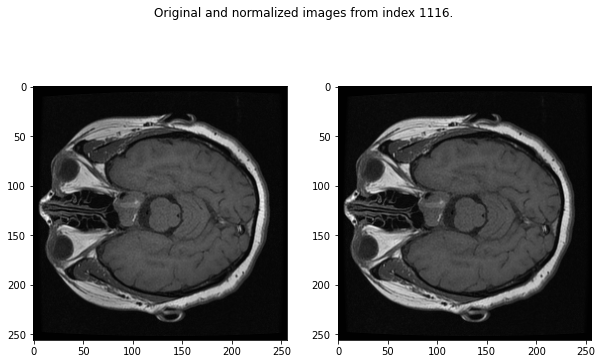

In [7]:
fig = plt.figure(figsize=(10,6))
fig.suptitle(f"Original and normalized images from index {idx}.")

sub_orig = fig.add_subplot(1,2,1).imshow(img_array, cmap='gray')
sub_rs = fig.add_subplot(1,2,2).imshow(norm_img_array, cmap='gray')

plt.show()

### Evaluate some stats for both images.

In [8]:
print(f"Original Image:\nMin value: {img_array.min()}; Max value: {img_array.max()}; Mean: {img_array.mean()}; Std: {img_array.std()}\n")
print(f"Original Image:\nMin value: {norm_img_array.min()}; Max value: {norm_img_array.max()}; Mean: {norm_img_array.mean()}; Std: {norm_img_array.std()}\n")

Original Image:
Min value: -4; Max value: 769; Mean: 142.8639373779297; Std: 145.59695715866553

Original Image:
Min value: -4.315950870513916; Max value: 780.8063354492188; Mean: 149.30242919921875; Std: 155.92068481445312



### Dataset should be rescaled to be in the range between 0 and 255.
### At first, let's check for current image if the steps (rescaling and normalization) are commutative.

In [9]:
rescaled_img_array = img_array - img_array.min()
rescaled_img_array = np.multiply(rescaled_img_array, 255.0/rescaled_img_array.max().astype(float))

print(f"Original Image:\nMin value: {rescaled_img_array.min()}; Max value: {rescaled_img_array.max()}; Mean: {rescaled_img_array.mean()}; Std: {rescaled_img_array.std()}\n")

Original Image:
Min value: 0.0; Max value: 255.0; Mean: 48.44800004058482; Std: 48.03004408209536



#### Rescaled normalized image

In [10]:
rescaled_norm_img_array = norm_img_array - norm_img_array.min()
rescaled_norm_img_array = np.multiply(rescaled_norm_img_array, 255.0/rescaled_norm_img_array.max().astype(float))

print(f"Normalized Image:\nMin value: {rescaled_norm_img_array.min()}; Max value: {rescaled_norm_img_array.max()}; Mean: {rescaled_norm_img_array.mean()}; Std: {rescaled_norm_img_array.std()}\n")

Normalized Image:
Min value: 0.0; Max value: 255.0; Mean: 49.893733978271484; Std: 50.64149856567383



#### Normalize rescaled image

In [11]:
rs_orig_image = sitk.GetImageFromArray(rescaled_img_array)
rs_img_mask = sitk.OtsuThreshold(rs_orig_image,0,1,200)

rs_orig_image_32 = sitk.Cast(rs_orig_image, sitk.sitkFloat32)
rs_corrector = sitk.N4BiasFieldCorrectionImageFilter()
rs_norm_image = corrector.Execute(rs_orig_image_32, img_mask)

norm_rs_img_array = sitk.GetArrayFromImage(rs_norm_image)

In [12]:
norm_rescaled_img_array = norm_rs_img_array - norm_rs_img_array.min()
norm_rescaled_img_array = np.multiply(norm_rescaled_img_array, 255.0/norm_rescaled_img_array.max().astype(float))

print(f"Normalized Image:\nMin value: {norm_rescaled_img_array.min()}; Max value: {norm_rescaled_img_array.max()}; Mean: {norm_rescaled_img_array.mean()}; Std: {norm_rescaled_img_array.std()}\n")

Normalized Image:
Min value: 0.0; Max value: 255.0; Mean: 49.85870361328125; Std: 50.664955139160156



## It was possible to verify that the operations are not commutative. In this context, the strategy adopted will be to rescale the entire Dataset to 0 to 255 before normalization.

In [19]:
images = brain_ds.Image

#new_images = list(map(lambda img: np.multiply(img - img.min(), 255.0/img.max()), images))
for img in images:
    img = img - img.min()
    img = np.multiply(img, 255.0/img.max())

brain_ds.Image = images

In [39]:
images = brain_ds.Image.to_numpy()
images = np.dstack(images)
images = np.transpose(images, (2, 0, 1))
images.shape

(1714, 256, 256)

## All images are now scaled between 0 and 255 and represented as a 3D numpy array.
## The next cell apply the N4ITK normalization in the entire Dataset. Since it takes hours to execute, the 3D array was saved and can be simply loaded in next session.

In [41]:
ds_stik_format = sitk.GetImageFromArray(images)
ds_mask = sitk.OtsuThreshold(ds_stik_format,0,1,200)

ds_32 = sitk.Cast(ds_stik_format, sitk.sitkFloat32)
corrector = sitk.N4BiasFieldCorrectionImageFilter()
norm_ds = corrector.Execute(ds_32, ds_mask)

norm_ds_array = sitk.GetArrayFromImage(norm_ds)

It took 1592347643.69 seconds to normalize the whole dataset.


In [42]:
norm_ds_array.shape

(1714, 256, 256)

In [45]:
np.save("N4ITK_normalized_ds.npy", norm_ds_array)

## Load normalized data and incorporate it into the dataset.

In [3]:
brain_ds = pd.read_pickle('merged_ds.pickle')
saved_norm_ds_array = np.load("N4ITK_normalized_ds.npy")
saved_norm_ds_array.shape

(1714, 256, 256)

In [4]:
saved_norm_ds_array[2].shape

(256, 256)

In [5]:
#new_Image = np.split(saved_norm_ds_array, len(saved_norm_ds_array), axis=0)
new_Image = list(map(lambda idx: saved_norm_ds_array[idx], range(len(saved_norm_ds_array))))
len(new_Image)

1714

In [6]:
new_brain_ds = brain_ds
new_brain_ds.Image = new_Image

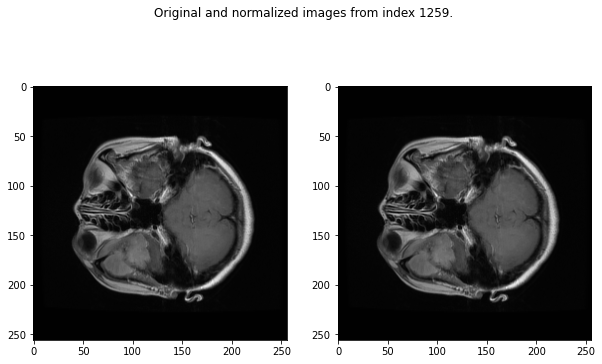

In [8]:
idx = random.choice(range(len(new_Image)))

fig = plt.figure(figsize=(10,6))
fig.suptitle(f"Original and normalized images from index {idx}.")

sub_orig = fig.add_subplot(1,2,1).imshow(brain_ds.loc[idx].Image, cmap='gray')
sub_rs = fig.add_subplot(1,2,2).imshow(new_brain_ds.loc[idx].Image, cmap='gray')

plt.show()

In [9]:
new_brain_ds.to_pickle('N4_norm_brain_ds.pickle')